Prediction of food production

pip install pmdarima
pip install fbprophet
pip install plotly

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")


In [2]:

import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline

plt.style.use('fivethirtyeight')

In [4]:
# Load datasets
df = pd.read_csv('Food_Products_Value.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head(2))
df.info()

326
            U11STI
Date              
1992-01-01   26169
1992-02-01   25992
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 326 entries, 1992-01-01 to 2019-02-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   U11STI  326 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [5]:
df.describe()

U11STI
count    326.000000
mean   38302.769939
std    10257.534604
min    24509.000000
25%    29756.750000
50%    33283.000000
75%    49295.250000
max    57819.000000

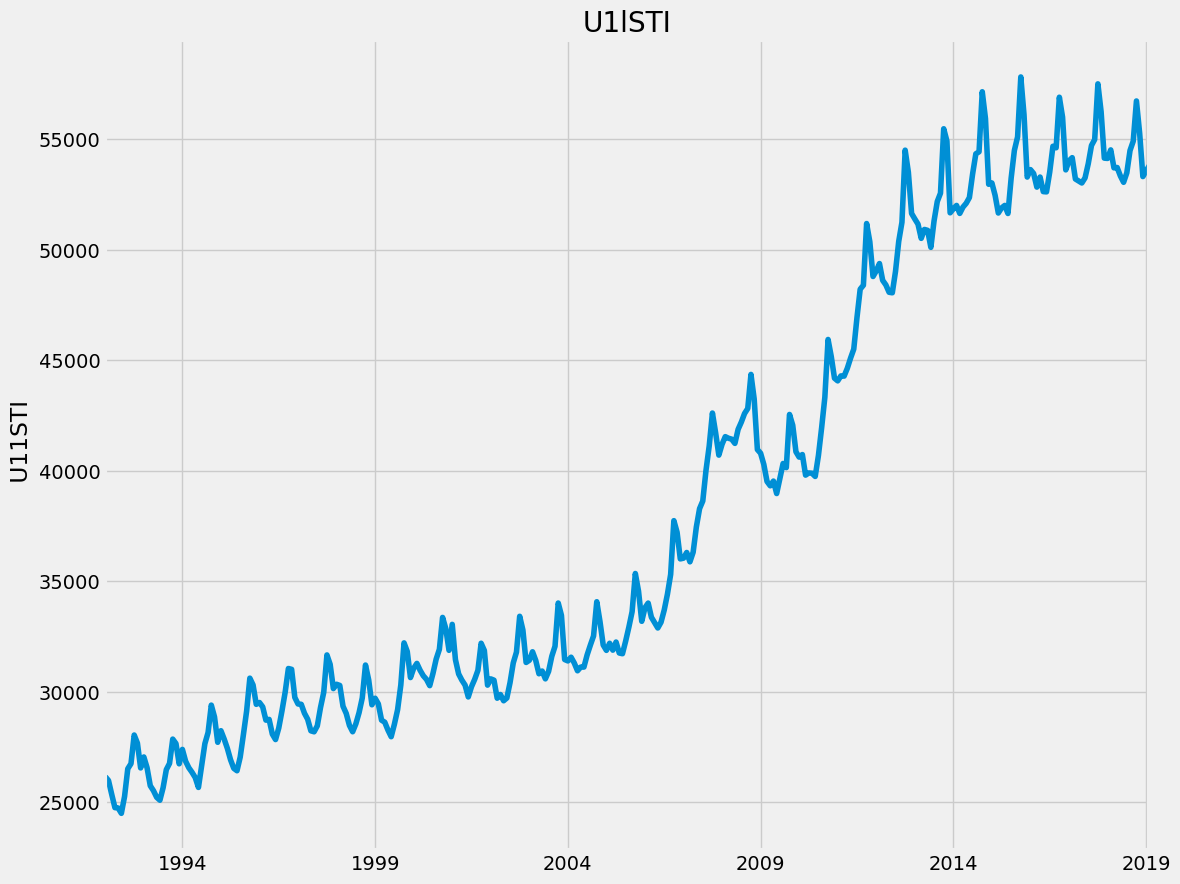

In [6]:
title='U1lSTI'
ylabel=' U11STI'
xlabel='' 

ax = df['U11STI'].plot(figsize=(12,10),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

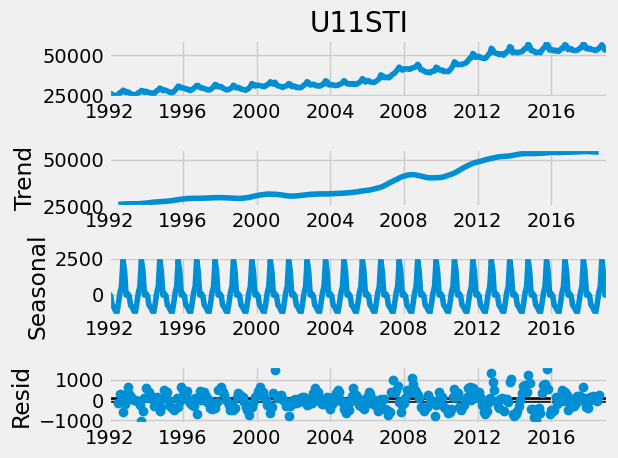

In [7]:
result = seasonal_decompose(df['U11STI'], model='add')
result.plot();

In [8]:
auto_arima(df['U11STI'],seasonal=True,m=12).summary()  #m= is number of periods , if 12 for monthly daata, m=1 for annual data  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  326
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2444.924
Date:                            Thu, 18 Nov 2021   AIC                           4897.848
Time:                                    10:17:12   BIC                           4912.983
Sample:                                         0   HQIC                          4903.889
                                            - 326                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0889      0.032      2.791      0.005       0.026       0.151
ar.S.L12       0.9625      0.010     95.672      0.000       0.943       0.982
ma.S.L12      -0.6930      0.038    -18.029      0.000      -0.768      -0.618
sigma2      1.436e+05   7841.236     18.312      0.000    1.28e+05    1.59e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.36   Jarque-Bera (JB):               159.48
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.65
Prob(H) (two-sided):                  0.22   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
#split tradn and test

train = df.iloc[:len(df)-20]
test = df.iloc[len(df)-20:]

In [10]:
# fit a SARIMAX(0, 1, 1)x(1, 0, 1, 12)
model = SARIMAX(train['U11STI'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             U11STI   No. Observations:                  306
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2302.800
Date:                            Thu, 18 Nov 2021   AIC                           4613.600
Time:                                    10:17:13   BIC                           4628.482
Sample:                                01-01-1992   HQIC                          4619.553
                                     - 06-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0898      0.033      2.761      0.006       0.026       0.154
ar.S.L12       0.9627      0.010     92.200      0.000       0.942       0.983
ma.S.L12      -0.6980      0.040    -17.669      0.000      -0.775      -0.621
sigma2      1.487e+05   8443.815     17.609      0.000    1.32e+05    1.65e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.48   Jarque-Bera (JB):               147.40
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -0.68
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Prediction
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0, 1, 1)(1, 0, 1, 12) Predictions')

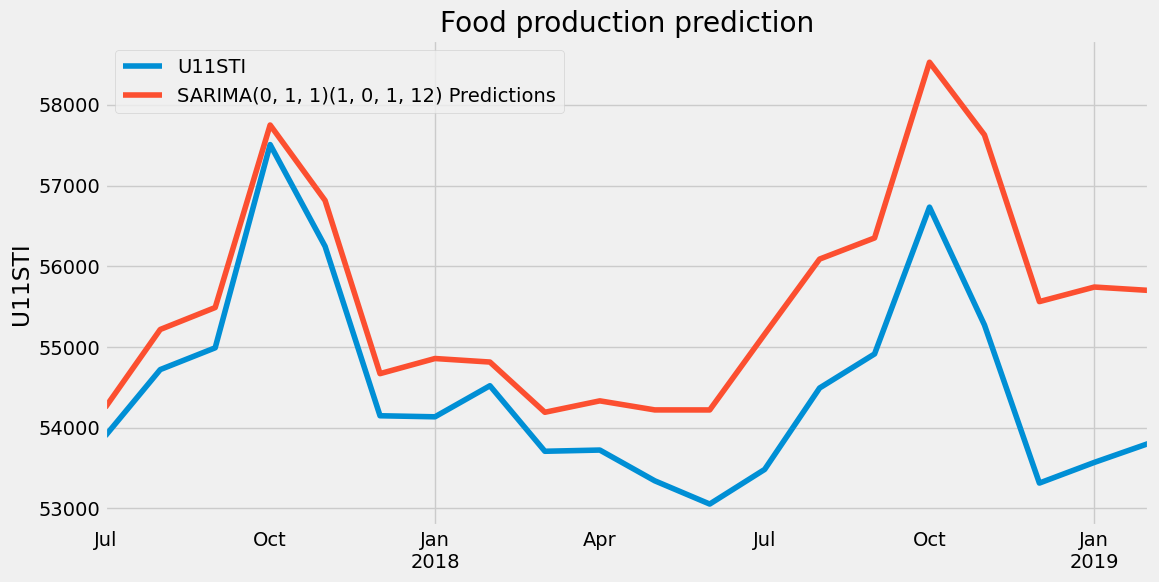

In [14]:
title='Food production prediction'
ylabel='U11STI'
xlabel=''

ax = test['U11STI'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [15]:
error1 = mean_squared_error(test['U11STI'], predictions)
error2 = rmse(test['U11STI'], predictions)
print(f'SARIMA(0, 1, 1)(1, 0, 1, 12) MSE Error: {error1}')
print(f'SARIMA(0, 1, 1)(1, 0, 1, 12) RMSE Error: {error2}')

SARIMA(0, 1, 1)(1, 0, 1, 12) MSE Error: 1708647.5045582387
SARIMA(0, 1, 1)(1, 0, 1, 12) RMSE Error: 1307.1524412088434


The Sarima method did not predict well, I try the prohpet model

In [3]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

In [4]:
df = pd.read_csv('Food_Products_Value.csv',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    326 non-null    object
 1   U11STI  326 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


In [5]:
df['Date'] = pd.DatetimeIndex(df['Date'])
df.dtypes

Date      datetime64[ns]
U11STI             int64
dtype: object

In [6]:
df.rename(columns = {'Date': 'ds','U11STI':'y'}, inplace = True)

In [7]:
df.head()

ds      y
0 1992-01-01  26169
1 1992-02-01  25992
2 1992-03-01  25367
3 1992-04-01  24766
4 1992-05-01  24749

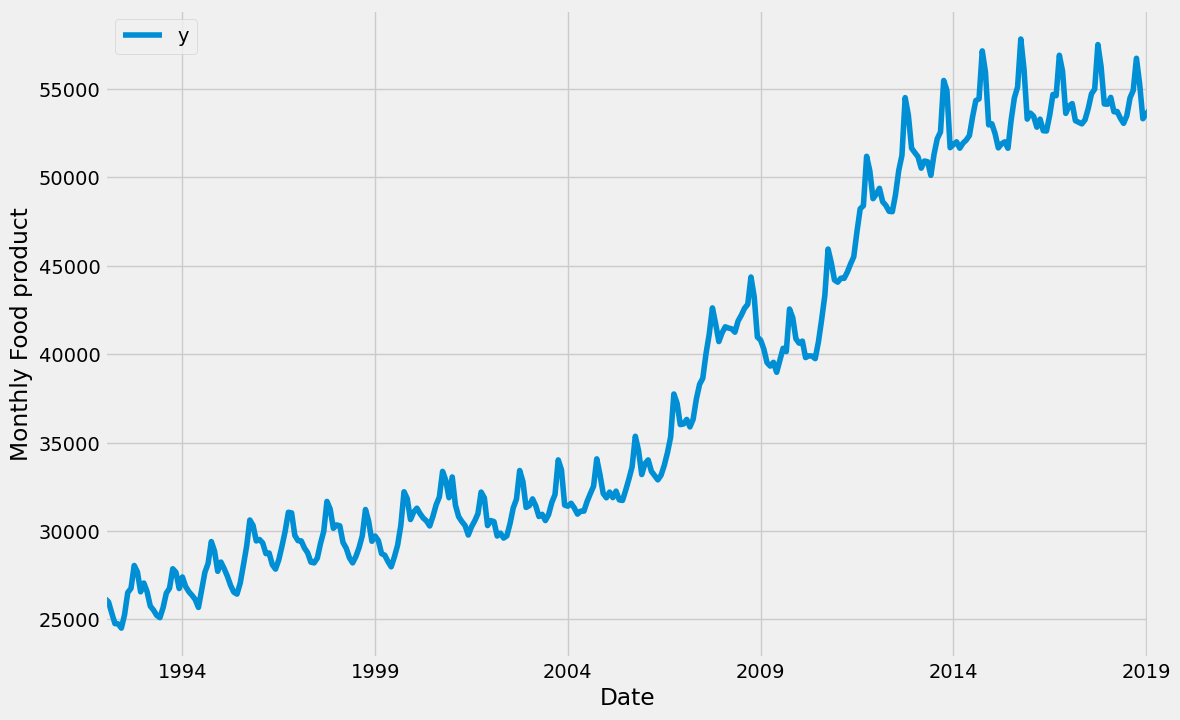

In [8]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Food product')
ax.set_xlabel('Date')

plt.show()

In [9]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

In [10]:
my_model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
future_dates = my_model.make_future_dataframe(periods=36, freq='M')
future_dates

ds
0   1992-01-01
1   1992-02-01
2   1992-03-01
3   1992-04-01
4   1992-05-01
..         ...
357 2021-09-30
358 2021-10-31
359 2021-11-30
360 2021-12-31
361 2022-01-31

[362 rows x 1 columns]

In [12]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds          yhat    yhat_lower    yhat_upper
0 1992-01-01  25639.041801  24346.659162  26960.614695
1 1992-02-01  25830.716886  24625.447116  27027.766794
2 1992-03-01  25155.318507  23896.769623  26436.599055
3 1992-04-01  24968.564501  23741.658478  26234.289121
4 1992-05-01  24616.695016  23310.771592  25882.240118

ds: the datestamp of the forecasted value
yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
yhat_lower: the lower bound of our forecasts
yhat_upper: the upper bound of our forecasts

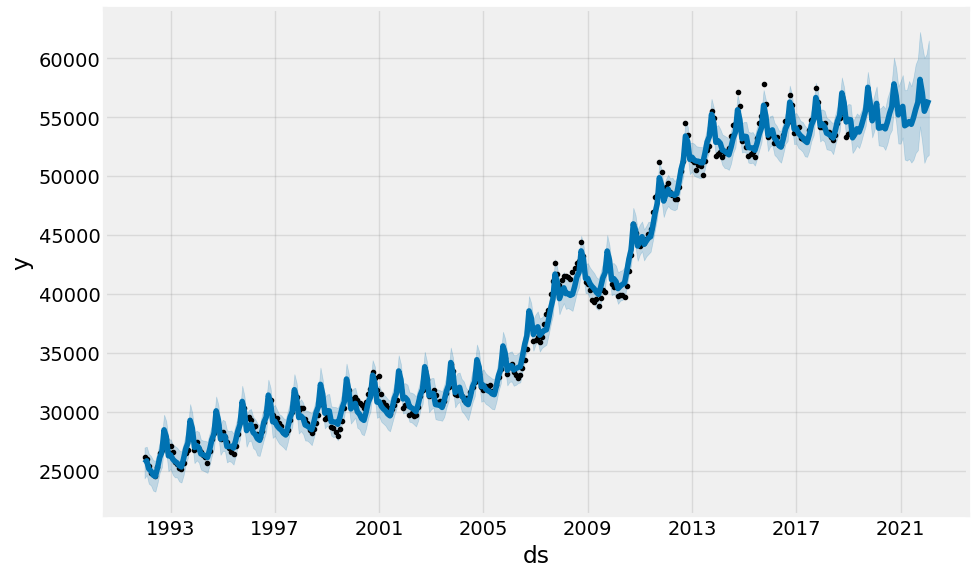

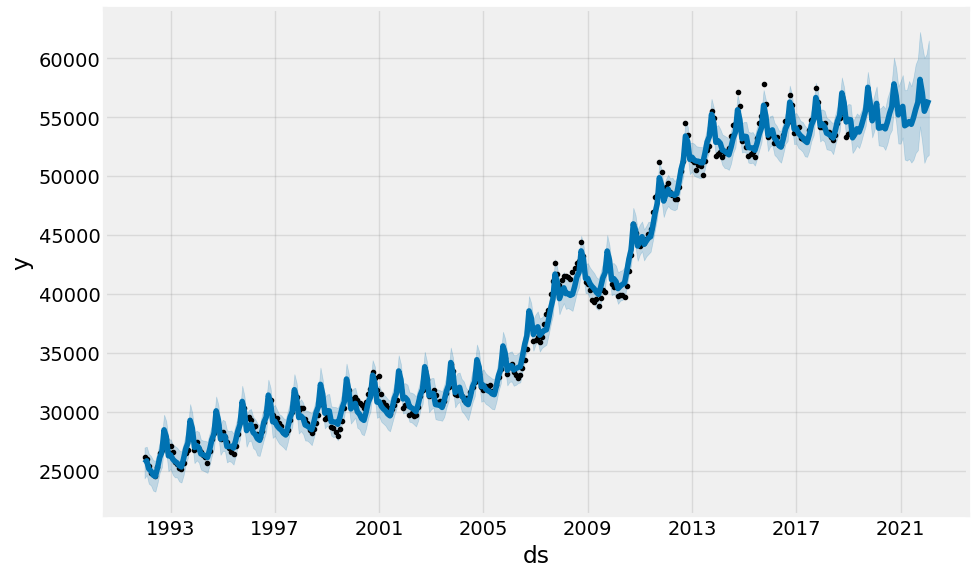

In [13]:
my_model.plot(forecast, uncertainty=True)

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions)

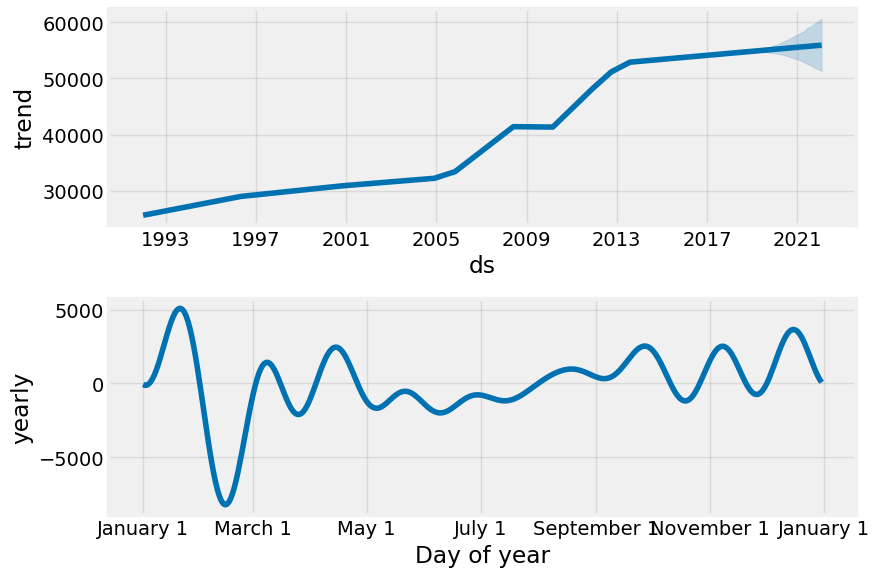

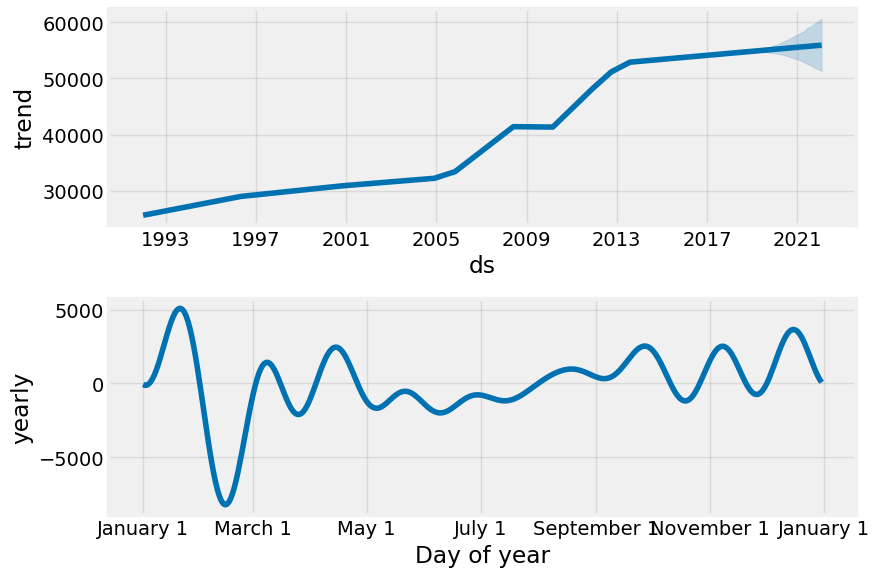

In [14]:
my_model.plot_components(forecast)

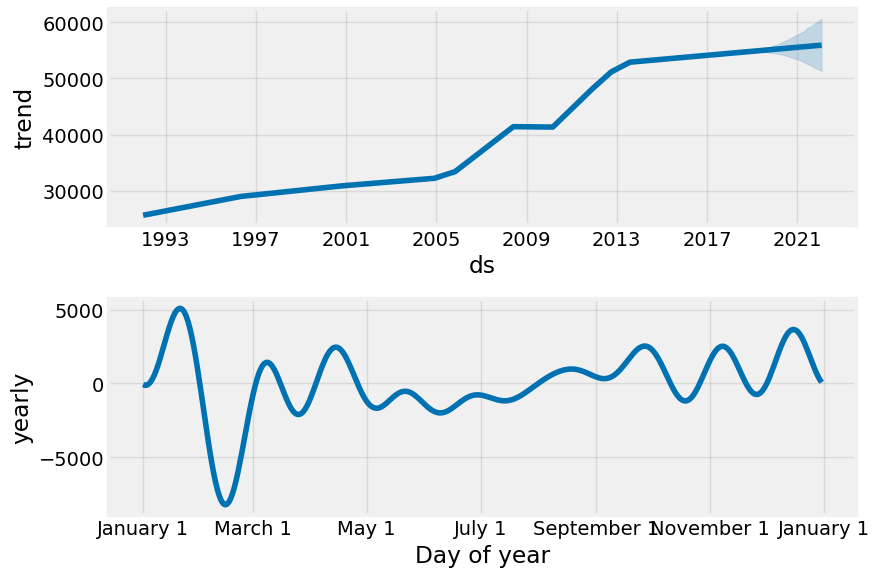

In [15]:
fig1 = my_model.plot_components(forecast)

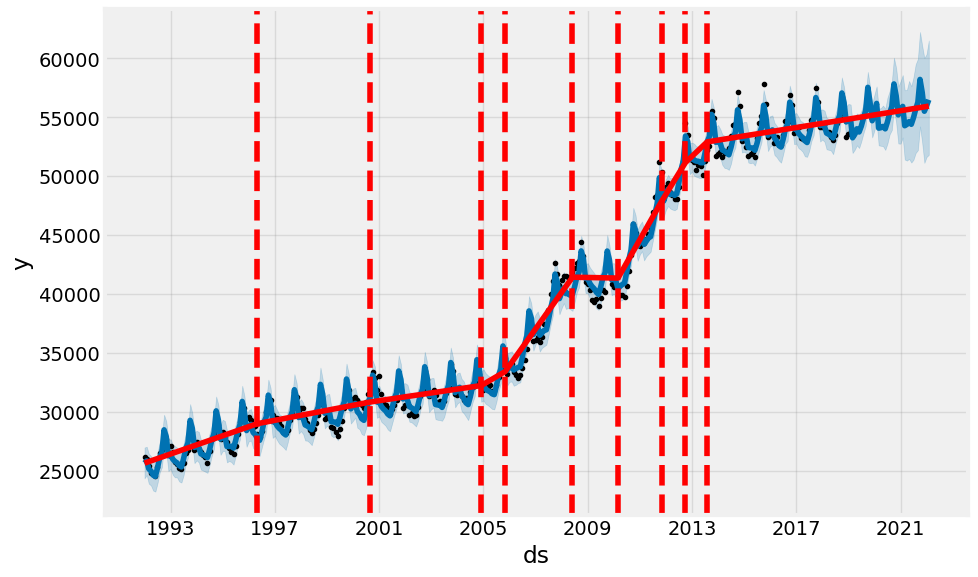

In [16]:
from fbprophet.plot import add_changepoints_to_plot
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

In [18]:
##cross validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, horizon = '365 days') ##initial= size of initial training perod # horizon= forecase horizon is what dates you want predict
# period= spacing between cutoff dates. cutoff=1/2(horizon) and initial= 3* horizon by default
df_cv.head()


INFO:fbprophet:Making 47 forecasts with cutoffs between 1995-02-07 00:00:00 and 2018-02-01 00:00:00


  0%|          | 0/47 [00:00<?, ?it/s]

ds          yhat    yhat_lower    yhat_upper      y     cutoff
0 1995-03-01  27275.698442  27175.709218  27380.308196  27447 1995-02-07
1 1995-04-01  27140.922053  27005.996048  27288.144960  26928 1995-02-07
2 1995-05-01  26562.556029  26344.817011  26776.654310  26544 1995-02-07
3 1995-06-01  26092.350803  25777.188276  26404.716709  26435 1995-02-07
4 1995-07-01  27183.942982  26753.438568  27609.898588  27054 1995-02-07

In [24]:
df_cv

ds          yhat    yhat_lower    yhat_upper      y     cutoff
0   1995-03-01  27275.698442  27175.709218  27380.308196  27447 1995-02-07
1   1995-04-01  27140.922053  27005.996048  27288.144960  26928 1995-02-07
2   1995-05-01  26562.556029  26344.817011  26776.654310  26544 1995-02-07
3   1995-06-01  26092.350803  25777.188276  26404.716709  26435 1995-02-07
4   1995-07-01  27183.942982  26753.438568  27609.898588  27054 1995-02-07
..         ...           ...           ...           ...    ...        ...
559 2018-10-01  57824.311824  56407.803087  59184.886696  56732 2018-02-01
560 2018-11-01  57033.504555  55684.439156  58547.652474  55272 2018-02-01
561 2018-12-01  55436.575716  54042.128133  57013.064857  53313 2018-02-01
562 2019-01-01  55667.866425  54192.400821  57198.941265  53569 2018-02-01
563 2019-02-01  55659.469672  54087.631343  57522.222856  53807 2018-02-01

[564 rows x 6 columns]

In [20]:
##metrics 
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse         rmse          mae      mape  \
0 54 days 12:00:00  2.201572e+06  1483.769666  1066.892249  0.026243   
1 55 days 00:00:00  2.275102e+06  1508.344026  1122.520745  0.028038   
2 55 days 12:00:00  2.285840e+06  1511.899304  1118.567766  0.027751   
3 56 days 00:00:00  2.314502e+06  1521.348893  1130.857892  0.027944   
4 56 days 12:00:00  2.520180e+06  1587.507399  1200.152350  0.029542   

      mdape  coverage  
0  0.020324  0.482143  
1  0.024125  0.446429  
2  0.022709  0.482143  
3  0.022315  0.491071  
4  0.024125  0.459821

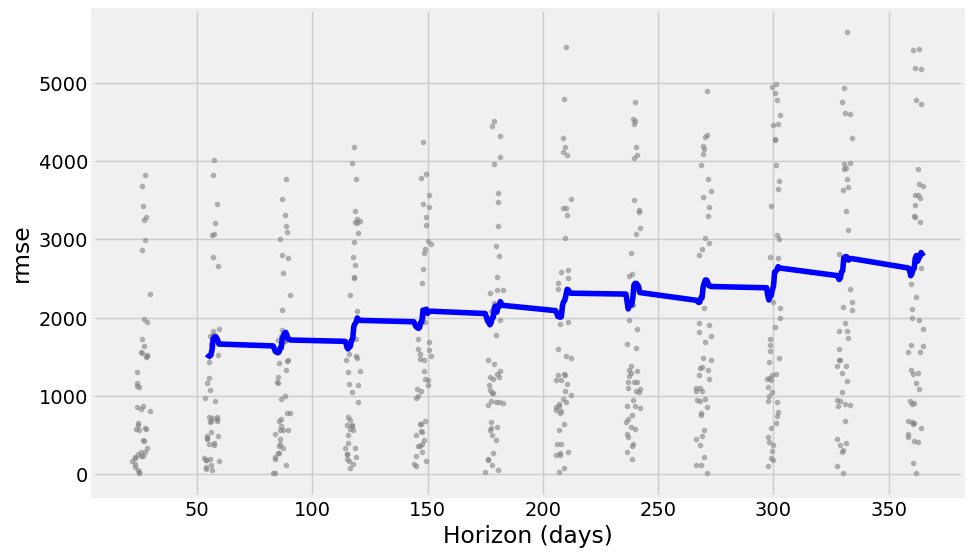

In [21]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')
